<a href="https://colab.research.google.com/github/sunnypatel3/hello-workd/blob/main/Spreetail_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.3 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=14cff050aec2a5a1fbc58c10e8f67a9d7d8aaf5400f0e1c5633f912951bdb6f8
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [2]:
from google.colab import files
upload = files.upload()

Saving forecasting_interview_data.csv to forecasting_interview_data.csv


In [3]:
from google.colab import files
upload1 = files.upload()

Saving Holidayswk2.csv to Holidayswk2.csv


In [4]:
#@author: sunnypatel
import pandas as pd
from fbprophet import Prophet
#from fbprophet.diagnostics import pss_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly
from scipy.stats import boxcox
import chart_studio.plotly as ply
import cufflinks as cf
import io

In [5]:
df = pd.read_csv(io.BytesIO(upload['forecasting_interview_data.csv']))
# df = pd.read_csv('C:/Users/Sunny Patel/Documents/Weekly Calls Prophet.csv', parse_dates=True)
#df['order_date'] = pd.to_datetime(df['order_date'].astype('str'),'%Y-%m-%d')
holidays = pd.read_csv(io.BytesIO(upload1['Holidayswk2.csv']))
holidays = holidays.dropna()
df = df.rename(columns = {'date': 'ds', 'units':'y'})
# df = df[['ds','y','product_id']]
list_p = df.product_id.unique()
df['ds'] = pd.to_datetime(df['ds'])     
df['product_id']  = df['product_id'].astype('str').str.replace(',',"")                          

In [6]:
print('Data Types: \n')
print(df.dtypes)
print('\n Stat Summary: \n')
print(df.describe())
print('\n Dataset size: \n')
print(df.shape)
print('\n Dataset basic info: \n')
print(df.info())
print('\n Dataset first 5 rows: \n')
print(df.tail(5))
print('\n Null counts: \n')
print(df.isnull().sum())

Data Types: 

snapshot_date               object
product_category            object
product_id                  object
ds                  datetime64[ns]
y                            int64
dtype: object

 Stat Summary: 

                y
count  394.000000
mean    23.720812
std     51.423782
min      0.000000
25%      1.000000
50%      6.000000
75%     20.000000
max    452.000000

 Dataset size: 

(394, 5)

 Dataset basic info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   snapshot_date     394 non-null    object        
 1   product_category  394 non-null    object        
 2   product_id        394 non-null    object        
 3   ds                394 non-null    datetime64[ns]
 4   y                 394 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 15.5+ KB
None

 Dataset

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



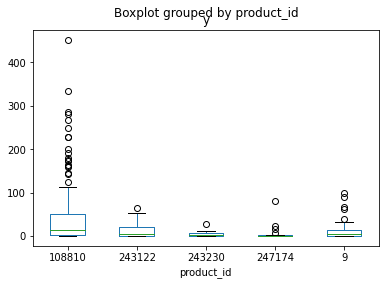

In [7]:
import seaborn as sns
df.boxplot(by = 'product_id', column = 'y', grid = False)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



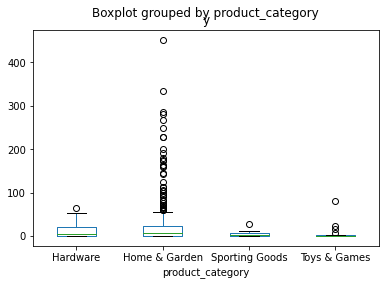

In [8]:
import seaborn as sns
df.boxplot(by = 'product_category', column = 'y', grid = False)

In [9]:
df_list = df['product_id'].unique()
print(df_list.shape)

#astype('str')

(5,)


In [16]:
def get_prediction(df, frequency, horizon, confidence_interval, growth, trend_flexibility):
    prediction = {}
    df_cv = {}
    df_p ={}
    count = 1
    list_p = df.product_id.unique()
    for p in list_p.tolist():
        p_df = df.loc[df['product_id'] == p]
        if (frequency == 'W' or frequency == 'm'):
            model = Prophet(yearly_seasonality = True, holidays = holidays, interval_width = confidence_interval, growth = growth, changepoint_prior_scale = trend_flexibility)
        elif frequency == '1D':
            model = Prophet(weekly_seasonality = True, yearly_seasonality = True, holidays = holidays, interval_width = confidence_interval, growth = growth, changepoint_prior_scale = trend_flexibility)
        elif frequency == 'H':
            model = Prophet(daily_seasonality = True, weekly_seasonality = True, yearly_seasonality = True, holidays = holidays, interval_width = confidence_interval, growth = growth, changepoint_prior_scale = trend_flexibility)
        else:
            model = Prophet(yearly_seasonality = True, holidays = holidays, interval_width = confidence_interval, growth = growth, changepoint_prior_scale = trend_flexibility)
        # model.add_country_holidays(country_name = country)
        model.fit(p_df)
        future = model.make_future_dataframe(periods = horizon, freq = frequency, include_history = True)
        future['floor'] = 0
        p_df['cap'] = max(p_df['y'])
        p_df['floor'] = 0
        future['cap'] = max(p_df['y'])
        future['floor'] = 0
        print(count)
        forecast = model.predict(future)
        prediction[p] = forecast
#        df_cv[p] = pss_validation(model, initial = '730 days', period = '90 days', horizon = '180 days')
#        df_p[p] = performance_metrics(df_cv[p])
#        print(p)
#        fig2 = plot_pss_validation_metric(df_cv[p], metric = 'rmse')
        fig1 = model.plot_components(prediction[p])
        print(p)
#        fig2 = model.iplot(prediction[p])
        fig = model.plot(prediction[p])
#        fig3 = model.plot_plotly(model[p], prediction[p])
        count = count+1
    return prediction

#function to pass data and run the model in loop  (dataframe, frequency, horizon, confidence interval reqd, linear/logistic growth, trend flexibility)   
#pred = get_prediction(df, 'W', 5, .95, 'linear', 0.09)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9
2


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


108810


INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


3


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


243122


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


4


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


243230


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


5
247174
{'9':             ds      trend  cap  yhat_lower  yhat_upper  trend_lower  \
0   2019-01-27  -1.823932  100  -29.256631   15.857864    -1.823932   
1   2019-02-03  -1.685966  100  -25.576508   14.585846    -1.685966   
2   2019-02-10  -1.548000  100  -26.515994   16.051778    -1.548000   
3   2019-02-17  -1.410034  100  -24.967531   16.119878    -1.410034   
4   2019-02-24  -1.272069  100  -25.822072   16.769130    -1.272069   
..         ...        ...  ...         ...         ...          ...   
158 2022-02-06  13.022760  100  -11.327488   28.669679    13.017158   
159 2022-02-13  12.994348  100  -10.629129   29.647983    12.970500   
160 2022-02-20  12.965937  100  -12.136790   28.743191    12.922591   
161 2022-02-27  12.937526  100  -12.401948   30.517534    12.870208   
162 2022-03-06  12.909114  100  -10.822950   32.307512    12.813449   

     trend_upper  COVID-19  COVID-19_lower  COVID-19_upper  ...  holidays  \
0      -1.823932       0.0             0.0             

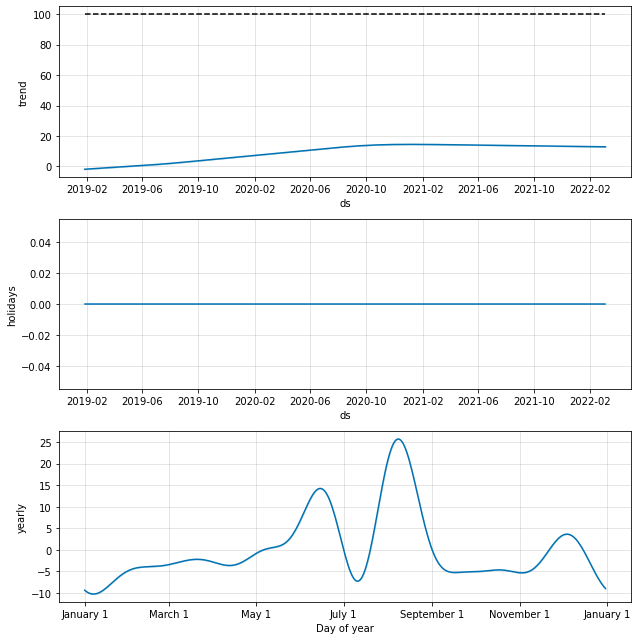

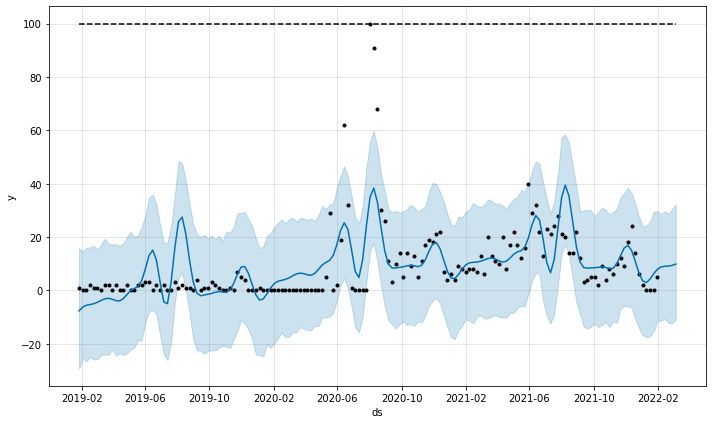

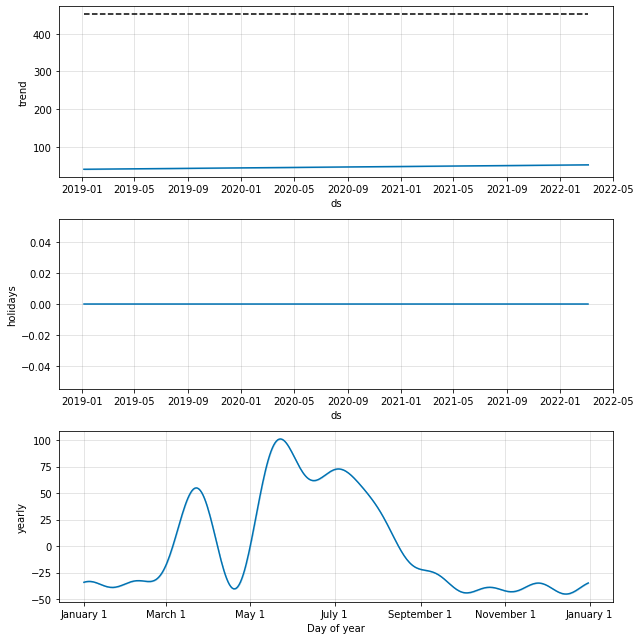

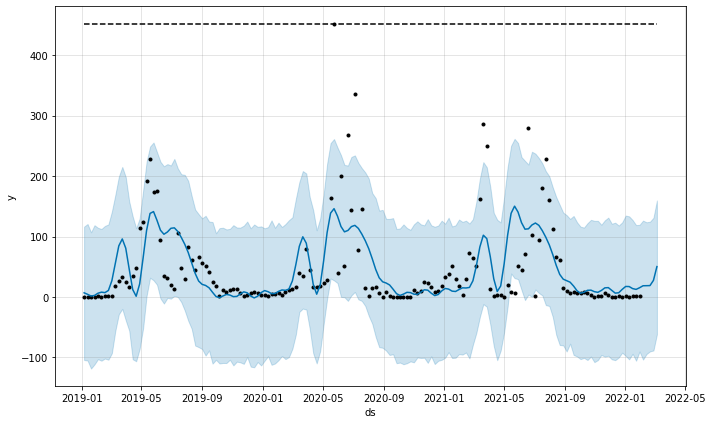

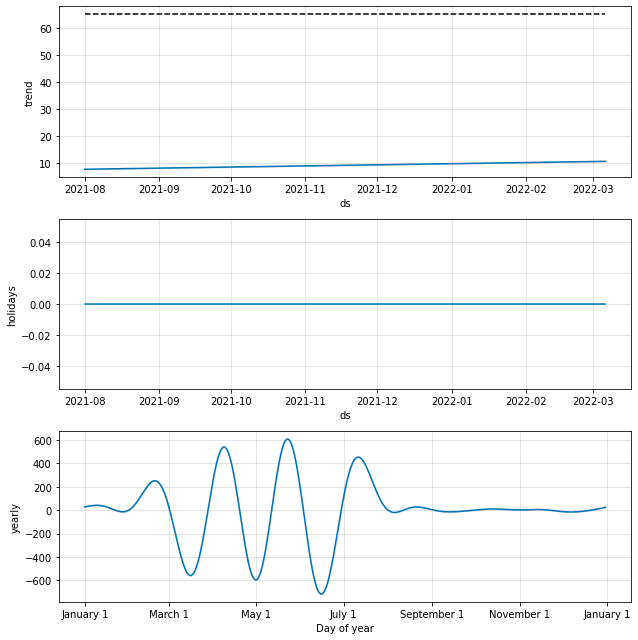

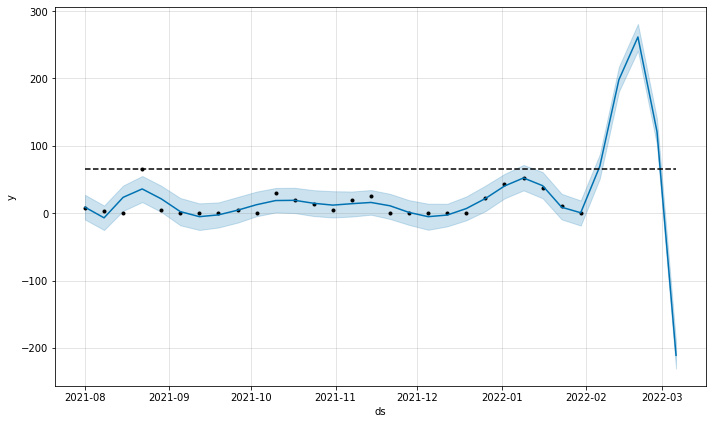

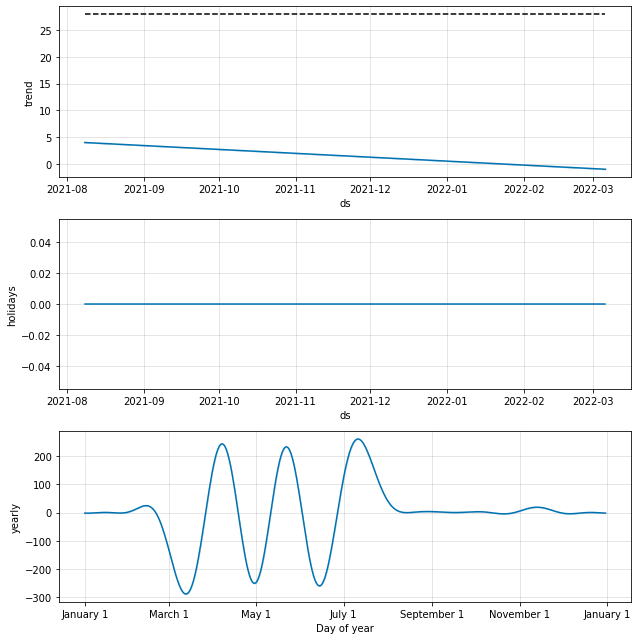

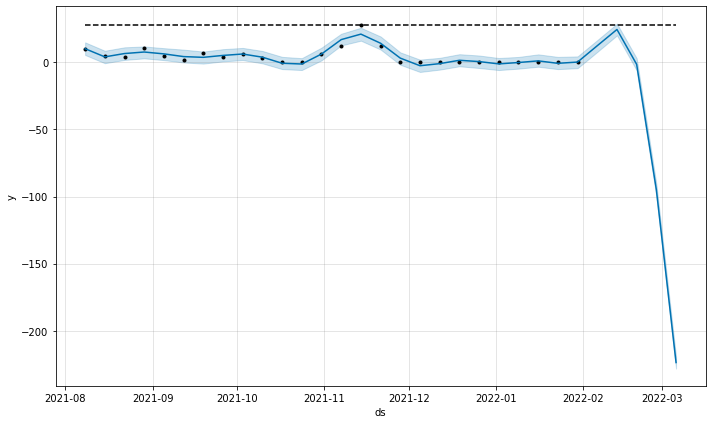

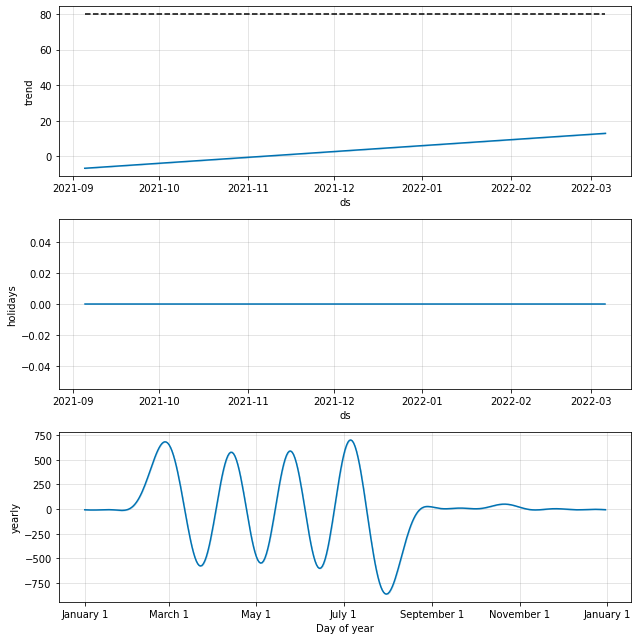

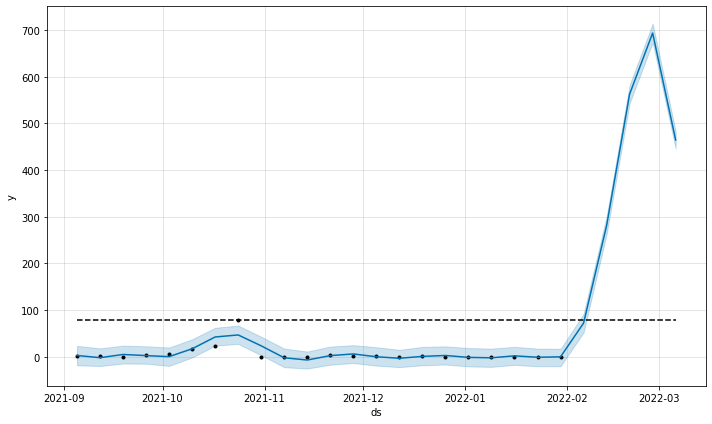

In [17]:
pred = get_prediction(df, 'W', 5, .95, 'linear', 0.09)
print(pred)

In [18]:
pred1 = get_prediction(df, 'W', 5, .95, 'logistic', 0.09)
print(pred1)

ValueError: ignored

In [ ]:
df1 = df.groupby(['ds'])['y'].sum()
df1.isnull().sum()
df1.head()
df1 = pd.DataFrame(df1)
df1 = df1.reset_index()

In [ ]:
df1.info()

In [ ]:
model = Prophet(yearly_seasonality = True, holidays = holidays, interval_width = 0.95, growth = 'linear', changepoint_prior_scale = 0.09)
model.fit(df1)
future = model.make_future_dataframe(periods = 5, freq = 'W', include_history = True)
future['floor'] = 0
df['cap'] = max(df['units'])
df['floor'] = 0
future['cap'] = 6
future['floor'] = 0
forecast = model.predict(future)
#        df_cv[p] = pss_validation(model, initial = '730 days', period = '90 days', horizon = '180 days')
#        df_p[p] = performance_metrics(df_cv[p])
#        print(p)
#        fig2 = plot_pss_validation_metric(df_cv[p], metric = 'rmse')
fig1 = model.plot_components(forecast)
#        fig2 = model.iplot(prediction[p])
fig = model.plot(forecast)
#        fig3 = model.plot_plotly(model[p], prediction[p])
#function to pass data and run the model in loop  (dataframe, frequency, horizon, confidence interval reqd, linear/logistic growth, trend flexibility)   
#pred = get_prediction(df, 'W', 5, .95, 'linear', 0.09)

ValueError: ignored